In [1]:
import sys
from pathlib import Path
module_path = Path('.').resolve().parent
if str(module_path) not in sys.path:
    sys.path.append(str(module_path))

from src.datagens._InMemoryGenerators import StockDatagenInMemmory
from src.training._Metrics import EpochMetrics, MetricsAccumulator, PerformanceMetrics

import torch.nn.functional as F
import torchvision.models as models
import torch
import torch.optim as optim
import pytorch_lightning as pl

import glob
import cv2
import pandas as pd
import pyreadr
import numpy as np
import ntpath
import time
from PIL import Image
import os
import random

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

In [2]:
mobilenet_v3_large = models.mobilenet_v3_large(pretrained = True, progress = True)
mobilenet_v3_large.classifier[3] = torch.nn.Linear(in_features = 1280, out_features = 1, bias = True)
mobilenet_v3_large.classifier.add_module(name = 'sigmoid_output', module = torch.nn.Sigmoid())

In [5]:
train_path = 'data_train'
label_path = 'data_labels'

In [6]:
stock_datagen = StockDatagenInMemmory(train_path, label_path)

Loading pickled data from the file: data_train
Loading pickled data from the file: data_labels


In [7]:
train_data_loader, val_data_loader, test_data_loader = stock_datagen.get_data_loaders(512, 256, 48)

Initialized Data Loaders:
 Train set size: 142095
Validation set size 19377
Test set size 40368


In [8]:
optimizer = optim.AdamW(mobilenet_v3_large.parameters(), lr=0.002, weight_decay = 0.01)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

mobilenet_v3_large.to(device)

Using device: cuda

Tesla V100-PCIE-32GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=

In [13]:
def print_gpu_mem():
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

### Base training for 3 epochs with large learning rate and weight decay

In [14]:
train_history = EpochMetrics()
val_history = EpochMetrics()
train_all_metrics = MetricsAccumulator()
val_all_metrics = MetricsAccumulator()
for epoch in range(3):

    train_metrics = PerformanceMetrics()
    mobilenet_v3_large.train()
    for i, (inputs, labels) in enumerate(train_data_loader, 0):
        
        inputs, labels = torch.squeeze(inputs.to(device)), torch.squeeze(labels.to(device))
        optimizer.zero_grad()

        outputs = torch.squeeze(mobilenet_v3_large(inputs))
        loss = F.binary_cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        outputs = torch.where(outputs < 0.5, 0, 1)
        train_metrics.update_metrics(loss.item(), outputs.cpu(), labels.cpu())
        train_history.update_metrics(loss.item(), outputs.cpu(), labels.cpu())
        train_all_metrics.update_metrics(loss.item(), outputs.cpu(), labels.cpu())
        if i % 10 == 9:
            print(f'[Epoch {epoch + 1}, {(i + 1)}/{len(train_data_loader)} batches done] ' + train_metrics.to_string(10))
            train_metrics.reset_metrics()
    print_gpu_mem()       
            
    mobilenet_v3_large.eval() 
    val_metrics = PerformanceMetrics()
    for inputs, labels in val_data_loader:
            
        inputs, labels = torch.squeeze(inputs.to(device)), torch.squeeze(labels.to(device))

        outputs =  torch.squeeze(mobilenet_v3_large(inputs))
        loss = F.binary_cross_entropy(outputs, labels)
        outputs = torch.where(outputs < 0.5, 0, 1)
        val_metrics.update_metrics(loss.item(), outputs.cpu(), labels.cpu())
        val_history.update_metrics(loss.item(), outputs.cpu(), labels.cpu())
        val_all_metrics.update_metrics(loss.item(), outputs.cpu(), labels.cpu())
    print(f'After Epoch {epoch + 1} >>>> Validation Metrics >>>> ' + val_metrics.to_string(len(val_data_loader)))
    train_history.start_new_epoch()
    val_history.start_new_epoch()

/home/ext_kantek/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ext_kantek/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ext_kantek/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ext_kantek/.local/lib/python3.8/site-packages/sklearn/metrics

[Epoch 1, 10/278 batches done] loss: 0.7709 | acc: 0.5088 | auc: 0.5067 | precision: 0.5007 | recall: 0.5088 | f1: 0.3985
[Epoch 1, 20/278 batches done] loss: 0.6869 | acc: 0.5316 | auc: 0.5308 | precision: 0.5378 | recall: 0.5316 | f1: 0.5186
[Epoch 1, 30/278 batches done] loss: 0.6729 | acc: 0.5703 | auc: 0.5703 | precision: 0.5725 | recall: 0.5703 | f1: 0.5681
[Epoch 1, 40/278 batches done] loss: 0.6669 | acc: 0.5883 | auc: 0.5832 | precision: 0.5966 | recall: 0.5883 | f1: 0.5752
[Epoch 1, 50/278 batches done] loss: 0.6459 | acc: 0.6152 | auc: 0.6160 | precision: 0.6225 | recall: 0.6152 | f1: 0.6105
[Epoch 1, 60/278 batches done] loss: 0.6355 | acc: 0.6156 | auc: 0.6160 | precision: 0.6169 | recall: 0.6156 | f1: 0.6156
[Epoch 1, 70/278 batches done] loss: 0.6295 | acc: 0.6293 | auc: 0.6287 | precision: 0.6350 | recall: 0.6293 | f1: 0.6257
[Epoch 1, 80/278 batches done] loss: 0.6195 | acc: 0.6346 | auc: 0.6340 | precision: 0.6383 | recall: 0.6346 | f1: 0.6324
[Epoch 1, 90/278 batches

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

After Epoch 1 >>>> Validation Metrics >>>> loss: 1.2224 | acc: 0.6760 | auc: 0.6765 | precision: 0.7088 | recall: 0.6760 | f1: 0.6634


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

[Epoch 2, 10/278 batches done] loss: 0.3269 | acc: 0.8615 | auc: 0.8614 | precision: 0.8640 | recall: 0.8615 | f1: 0.8614
[Epoch 2, 20/278 batches done] loss: 0.3032 | acc: 0.8691 | auc: 0.8696 | precision: 0.8703 | recall: 0.8691 | f1: 0.8692
[Epoch 2, 30/278 batches done] loss: 0.2978 | acc: 0.8760 | auc: 0.8765 | precision: 0.8770 | recall: 0.8760 | f1: 0.8760
[Epoch 2, 40/278 batches done] loss: 0.2943 | acc: 0.8742 | auc: 0.8743 | precision: 0.8750 | recall: 0.8742 | f1: 0.8742
[Epoch 2, 50/278 batches done] loss: 0.2805 | acc: 0.8816 | auc: 0.8817 | precision: 0.8836 | recall: 0.8816 | f1: 0.8816
[Epoch 2, 60/278 batches done] loss: 0.2577 | acc: 0.8984 | auc: 0.8993 | precision: 0.9012 | recall: 0.8984 | f1: 0.8984
[Epoch 2, 70/278 batches done] loss: 0.2524 | acc: 0.8943 | auc: 0.8955 | precision: 0.8969 | recall: 0.8943 | f1: 0.8943
[Epoch 2, 80/278 batches done] loss: 0.2309 | acc: 0.9051 | auc: 0.9053 | precision: 0.9059 | recall: 0.9051 | f1: 0.9051
[Epoch 2, 90/278 batches

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Memory Usage:
Allocated: 0.3 GB
Cached:    28.4 GB


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

After Epoch 2 >>>> Validation Metrics >>>> loss: 0.5646 | acc: 0.8436 | auc: 0.8439 | precision: 0.8579 | recall: 0.8436 | f1: 0.8422


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

[Epoch 3, 10/278 batches done] loss: 0.0749 | acc: 0.9717 | auc: 0.9718 | precision: 0.9720 | recall: 0.9717 | f1: 0.9717
[Epoch 3, 20/278 batches done] loss: 0.0653 | acc: 0.9760 | auc: 0.9761 | precision: 0.9762 | recall: 0.9760 | f1: 0.9760
[Epoch 3, 30/278 batches done] loss: 0.0623 | acc: 0.9750 | auc: 0.9753 | precision: 0.9753 | recall: 0.9750 | f1: 0.9750
[Epoch 3, 40/278 batches done] loss: 0.0530 | acc: 0.9825 | auc: 0.9826 | precision: 0.9826 | recall: 0.9825 | f1: 0.9825
[Epoch 3, 50/278 batches done] loss: 0.0658 | acc: 0.9764 | auc: 0.9763 | precision: 0.9765 | recall: 0.9764 | f1: 0.9764
[Epoch 3, 60/278 batches done] loss: 0.0530 | acc: 0.9791 | auc: 0.9793 | precision: 0.9792 | recall: 0.9791 | f1: 0.9791
[Epoch 3, 70/278 batches done] loss: 0.0569 | acc: 0.9795 | auc: 0.9797 | precision: 0.9797 | recall: 0.9795 | f1: 0.9795
[Epoch 3, 80/278 batches done] loss: 0.0574 | acc: 0.9807 | auc: 0.9809 | precision: 0.9810 | recall: 0.9807 | f1: 0.9807
[Epoch 3, 90/278 batches

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Memory Usage:
Allocated: 0.3 GB
Cached:    28.4 GB


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

After Epoch 3 >>>> Validation Metrics >>>> loss: 0.2855 | acc: 0.9221 | auc: 0.9222 | precision: 0.9253 | recall: 0.9221 | f1: 0.9219


### Training for one more epoch with smaller learning rate

In [15]:
optimizer = optim.AdamW(mobilenet_v3_large.parameters(), lr=0.00002, weight_decay = 0.01)

In [16]:
train_history2 = EpochMetrics()
val_history2 = EpochMetrics()
train_all_metrics2 = MetricsAccumulator()
val_all_metrics2 = MetricsAccumulator()
for epoch in range(1):

    train_metrics2 = PerformanceMetrics()
    mobilenet_v3_large.train()
    for i, (inputs, labels) in enumerate(train_data_loader, 0):
        
        inputs, labels = torch.squeeze(inputs.to(device)), torch.squeeze(labels.to(device))
        optimizer.zero_grad()

        outputs = torch.squeeze(mobilenet_v3_large(inputs))
        loss = F.binary_cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        outputs = torch.where(outputs < 0.5, 0, 1)
        train_metrics2.update_metrics(loss.item(), outputs.cpu(), labels.cpu())
        train_history2.update_metrics(loss.item(), outputs.cpu(), labels.cpu())
        train_all_metrics2.update_metrics(loss.item(), outputs.cpu(), labels.cpu())
        if i % 10 == 9:
            print(f'[Epoch {epoch + 1}, {(i + 1)}/{len(train_data_loader)} batches done] ' + train_metrics2.to_string(10))
            train_metrics2.reset_metrics()
    print_gpu_mem()       
            
    mobilenet_v3_large.eval() 
    val_metrics2 = PerformanceMetrics()
    for inputs, labels in val_data_loader:
            
        inputs, labels = torch.squeeze(inputs.to(device)), torch.squeeze(labels.to(device))

        outputs =  torch.squeeze(mobilenet_v3_large(inputs))
        loss = F.binary_cross_entropy(outputs, labels)
        outputs = torch.where(outputs < 0.5, 0, 1)
        val_metrics2.update_metrics(loss.item(), outputs.cpu(), labels.cpu())
        val_history2.update_metrics(loss.item(), outputs.cpu(), labels.cpu())
        val_all_metrics2.update_metrics(loss.item(), outputs.cpu(), labels.cpu())
    print(f'After Epoch {epoch + 1} >>>> Validation Metrics >>>> ' + val_metrics2.to_string(len(val_data_loader)))
    train_history2.start_new_epoch()
    val_history2.start_new_epoch()

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

[Epoch 1, 10/278 batches done] loss: 0.0269 | acc: 0.9896 | auc: 0.9898 | precision: 0.9897 | recall: 0.9896 | f1: 0.9896
[Epoch 1, 20/278 batches done] loss: 0.0244 | acc: 0.9902 | auc: 0.9903 | precision: 0.9903 | recall: 0.9902 | f1: 0.9902
[Epoch 1, 30/278 batches done] loss: 0.0217 | acc: 0.9932 | auc: 0.9933 | precision: 0.9932 | recall: 0.9932 | f1: 0.9932
[Epoch 1, 40/278 batches done] loss: 0.0204 | acc: 0.9932 | auc: 0.9932 | precision: 0.9932 | recall: 0.9932 | f1: 0.9932
[Epoch 1, 50/278 batches done] loss: 0.0154 | acc: 0.9947 | auc: 0.9948 | precision: 0.9947 | recall: 0.9947 | f1: 0.9947
[Epoch 1, 60/278 batches done] loss: 0.0161 | acc: 0.9953 | auc: 0.9953 | precision: 0.9953 | recall: 0.9953 | f1: 0.9953
[Epoch 1, 70/278 batches done] loss: 0.0139 | acc: 0.9959 | auc: 0.9959 | precision: 0.9959 | recall: 0.9959 | f1: 0.9959
[Epoch 1, 80/278 batches done] loss: 0.0118 | acc: 0.9959 | auc: 0.9959 | precision: 0.9959 | recall: 0.9959 | f1: 0.9959
[Epoch 1, 90/278 batches

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Memory Usage:
Allocated: 0.3 GB
Cached:    28.4 GB


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

After Epoch 1 >>>> Validation Metrics >>>> loss: 0.0103 | acc: 0.9966 | auc: 0.9966 | precision: 0.9967 | recall: 0.9966 | f1: 0.9966


In [52]:
val_history2.history

{'epoch1': {'loss': 0.010326243691930645,
  'acc': 0.9966361879274458,
  'f1': 0.9966363051694714,
  'auc': 0.9966432587111803,
  'precision': 0.9966596779902632,
  'recall': 0.9966361879274458}}

### Save the whole resulting model

In [17]:
torch.save(mobilenet_v3_large, 'mobilenetv3_best_susp.pth')

### Testing

In [18]:
test_metrics = PerformanceMetrics()
for inputs, labels in test_data_loader:
    inputs, labels = torch.squeeze(inputs.to(device)), torch.squeeze(labels.to(device))

    outputs =  torch.squeeze(mobilenet_v3_large(inputs))
    loss = F.binary_cross_entropy(outputs, labels)
    outputs = torch.where(outputs < 0.5, 0, 1)
    test_metrics.update_metrics(loss.item(), outputs.cpu(), labels.cpu())
print(f'Test Metrics >>>> ' + test_metrics.to_string(len(test_data_loader)))

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Test Metrics >>>> loss: 0.0106 | acc: 0.9963 | auc: 0.9963 | precision: 0.9964 | recall: 0.9963 | f1: 0.9963


# Confusion Matrix

In [ ]:
preds = []
y = []

In [29]:
for inputs, labels in test_data_loader:
    inputs, labels = torch.squeeze(inputs.to(device)), torch.squeeze(labels.to(device))

    outputs =  torch.squeeze(mobilenet_v3_large(inputs))
    outputs = torch.where(outputs < 0.5, 0, 1)
    preds += outputs.cpu().detach().numpy().tolist()
    y += labels.cpu().detach().numpy().tolist()

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

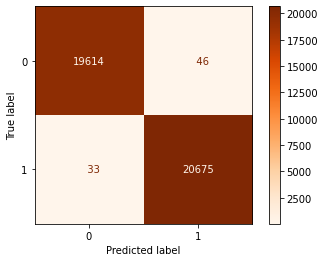

In [43]:
# plot_confusion_matrix(clf, X_test, y_test)  
# plt.show()  
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y, preds)).plot(values_format = '5d', cmap='Oranges')

### See the performance metrics and make plots

In [ ]:
train_all_metrics2.acc

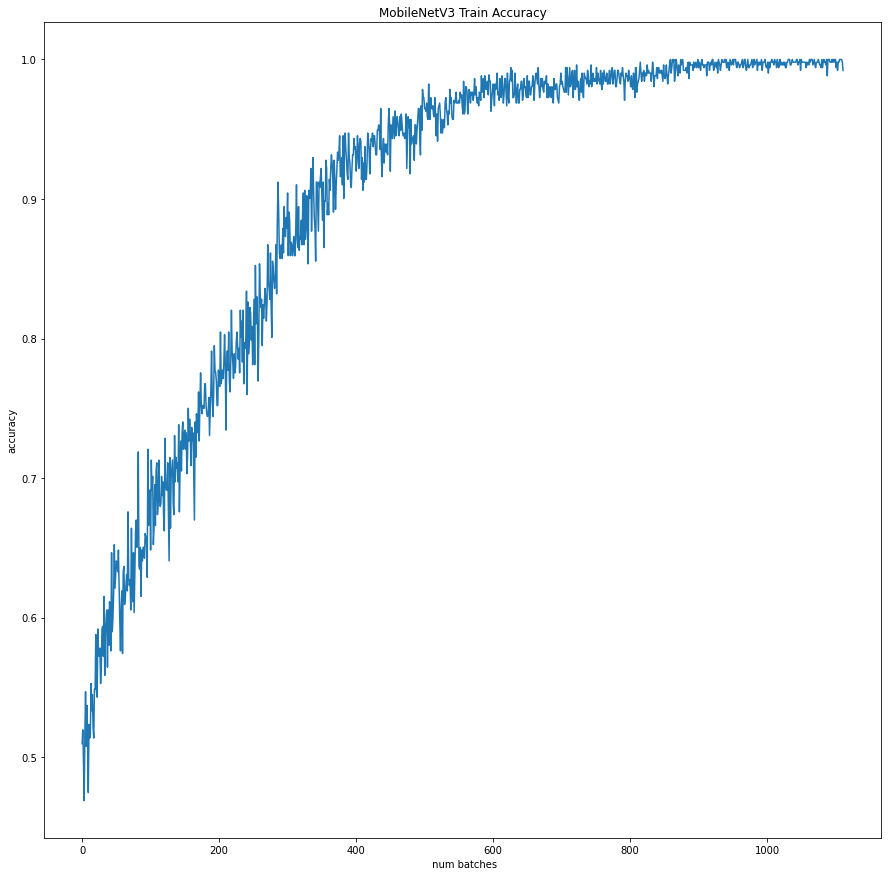

In [24]:
plt.figure(figsize=(15, 15))
plt.plot( train_all_metrics.acc + train_all_metrics2.acc)
plt.title('MobileNetV3 Train Accuracy')
plt.ylabel('accuracy')
plt.xlabel(' num batches')
plt.show()

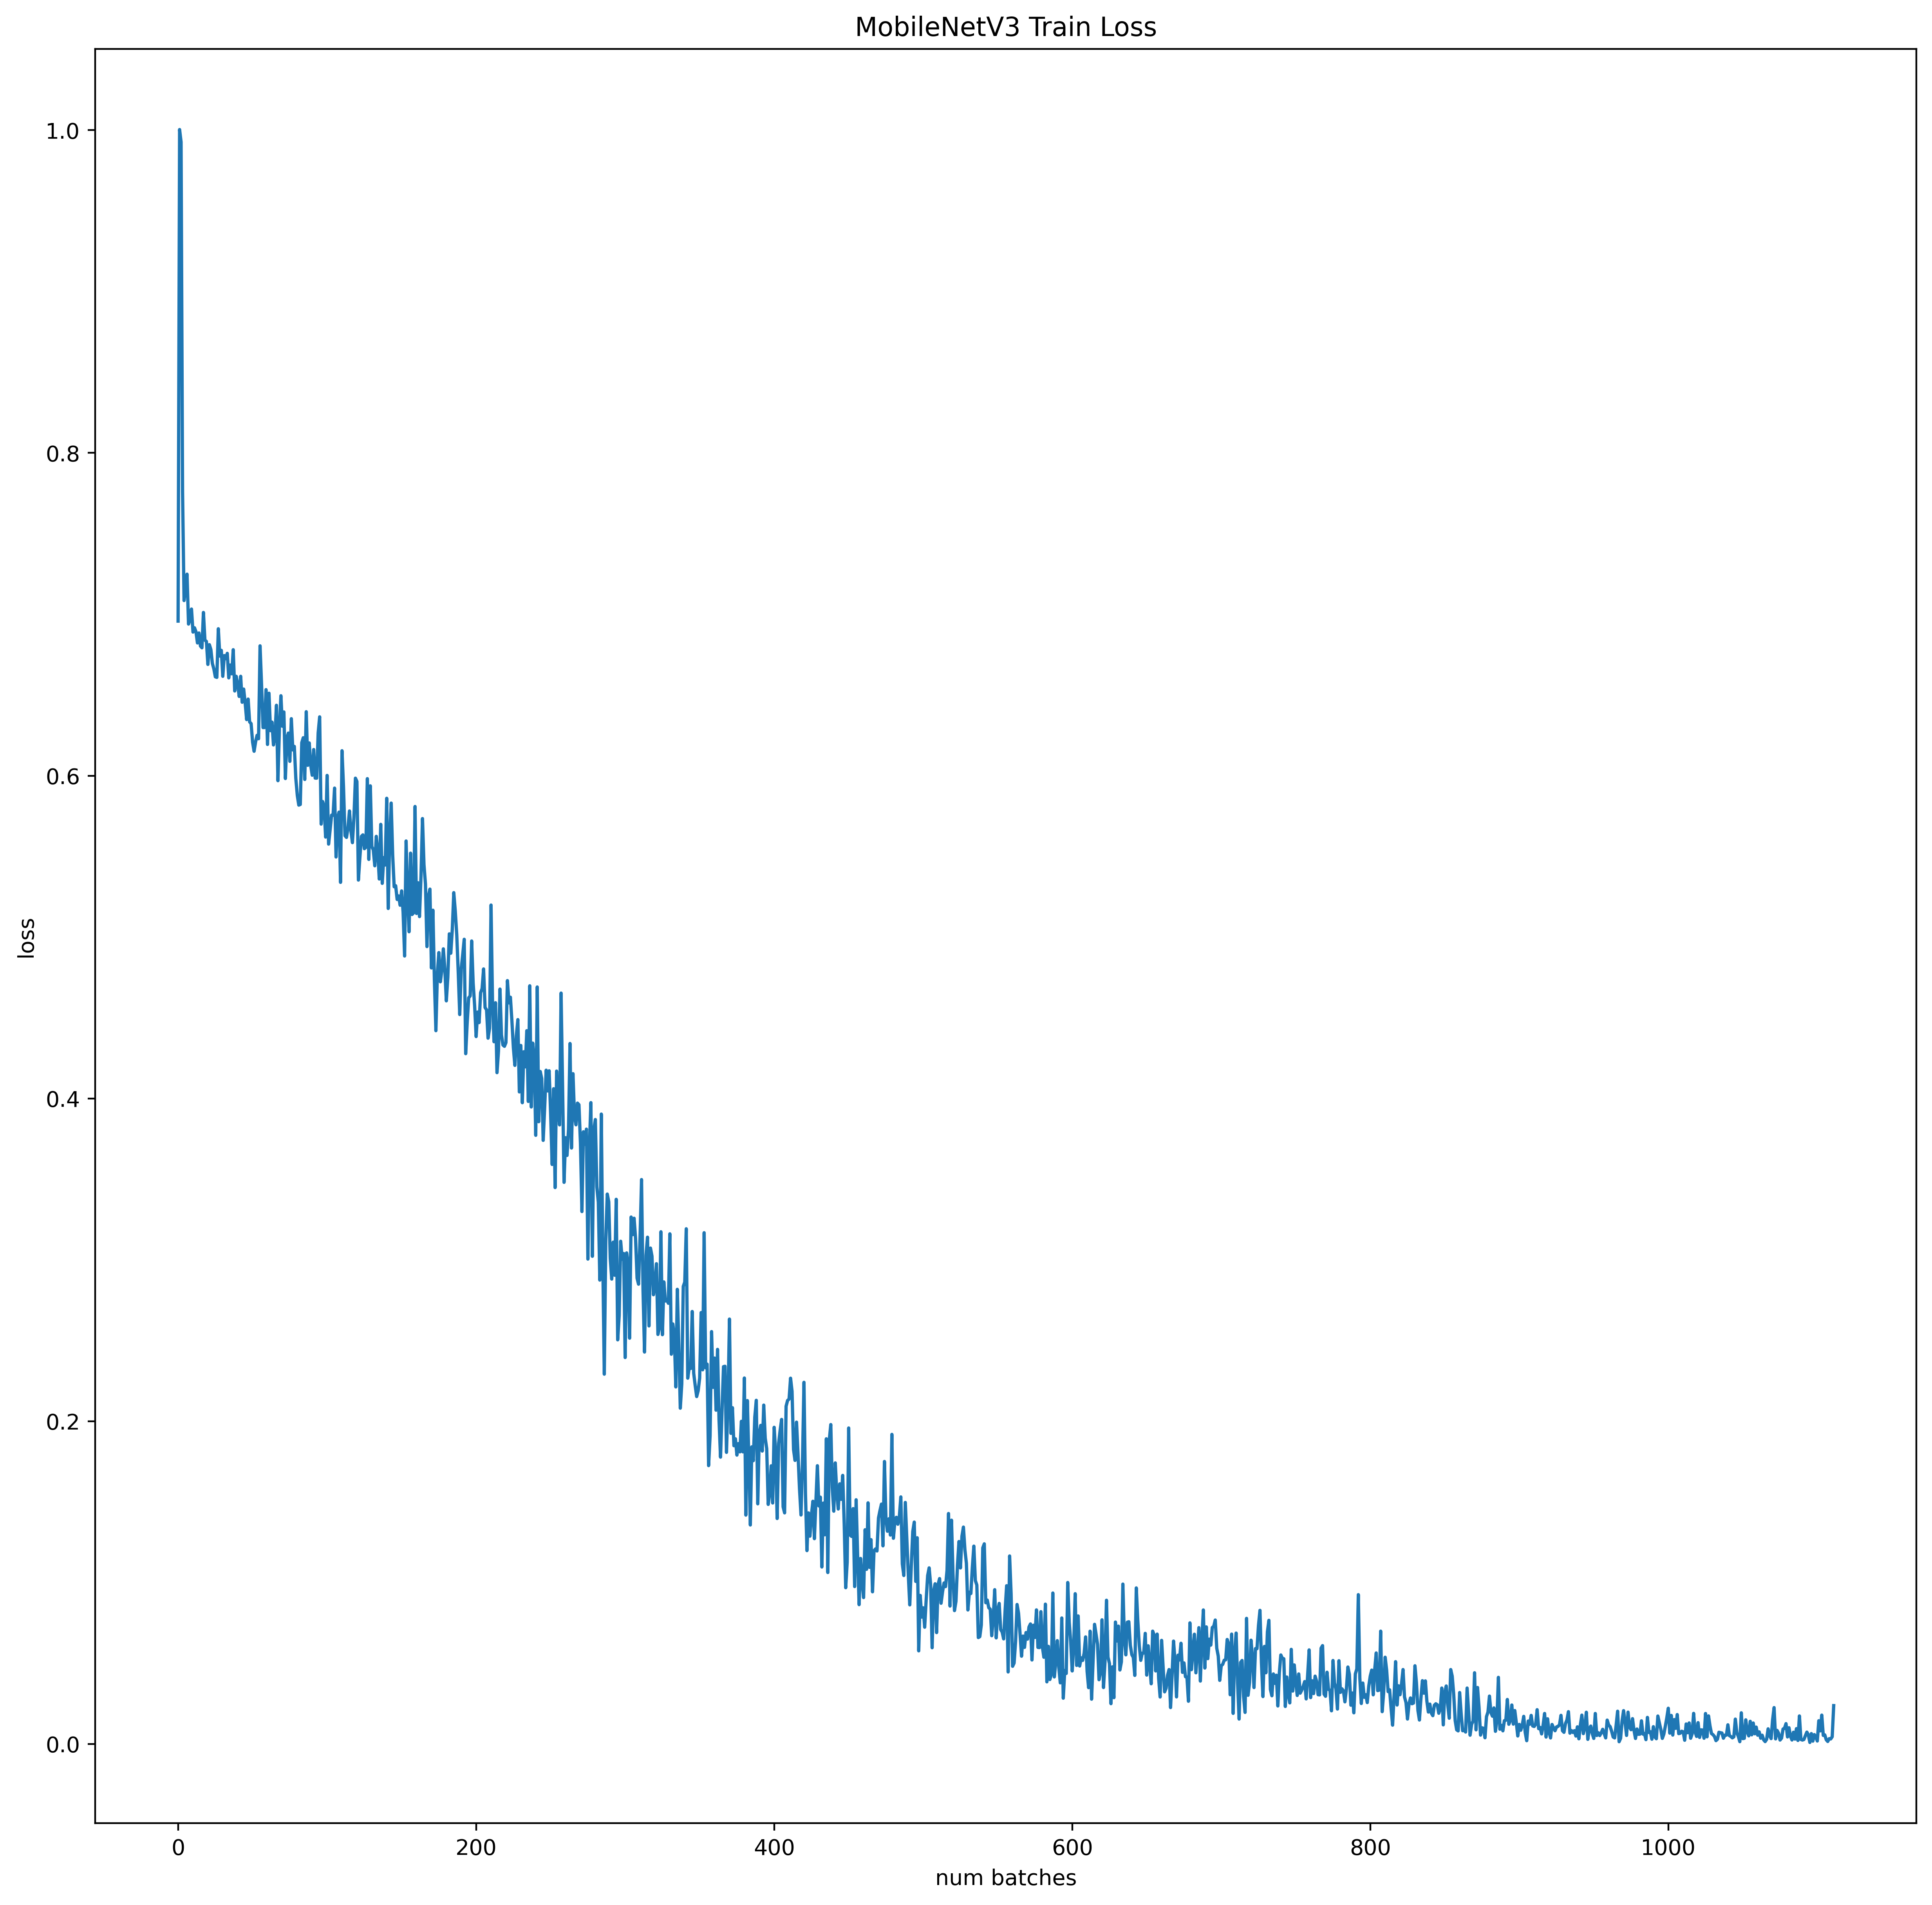

In [84]:
plt.figure(figsize=(15, 15), dpi=400)
plt.plot( train_all_metrics.loss + train_all_metrics2.loss)
plt.title('MobileNetV3 Train Loss')
plt.ylabel('loss')
plt.xlabel('num batches')
plt.show()

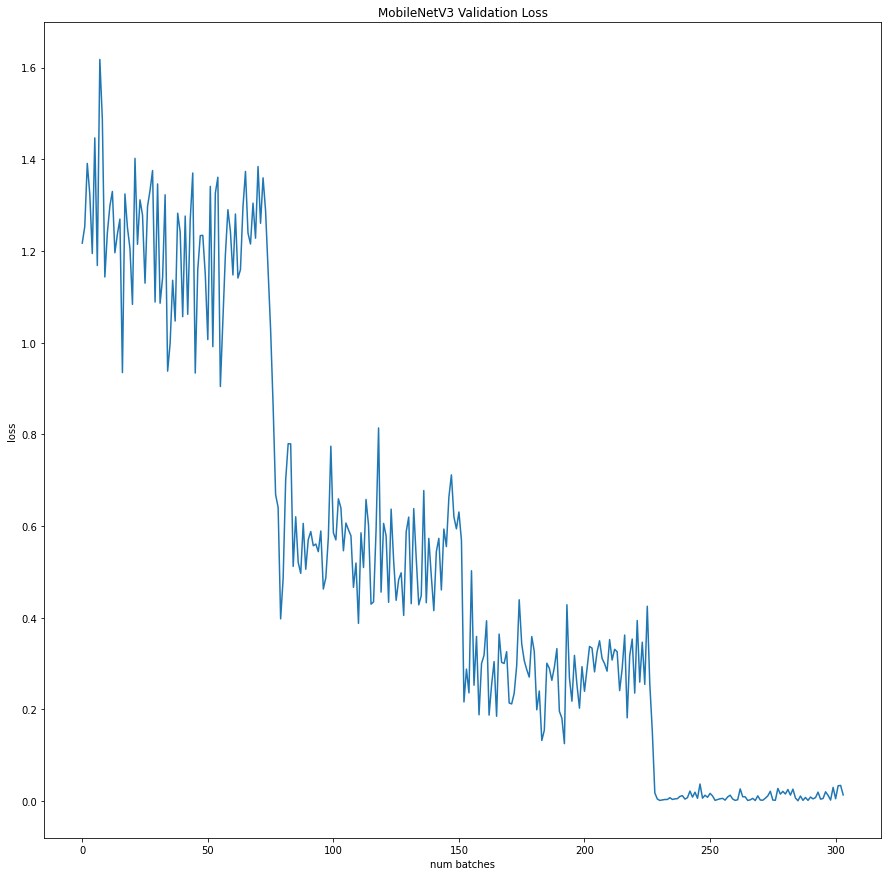

In [29]:
plt.figure(figsize=(15, 15))
plt.plot( val_all_metrics.loss + val_all_metrics2.loss)
plt.title('MobileNetV3 Validation Loss')
plt.ylabel('loss')
plt.xlabel('num batches')
plt.show()

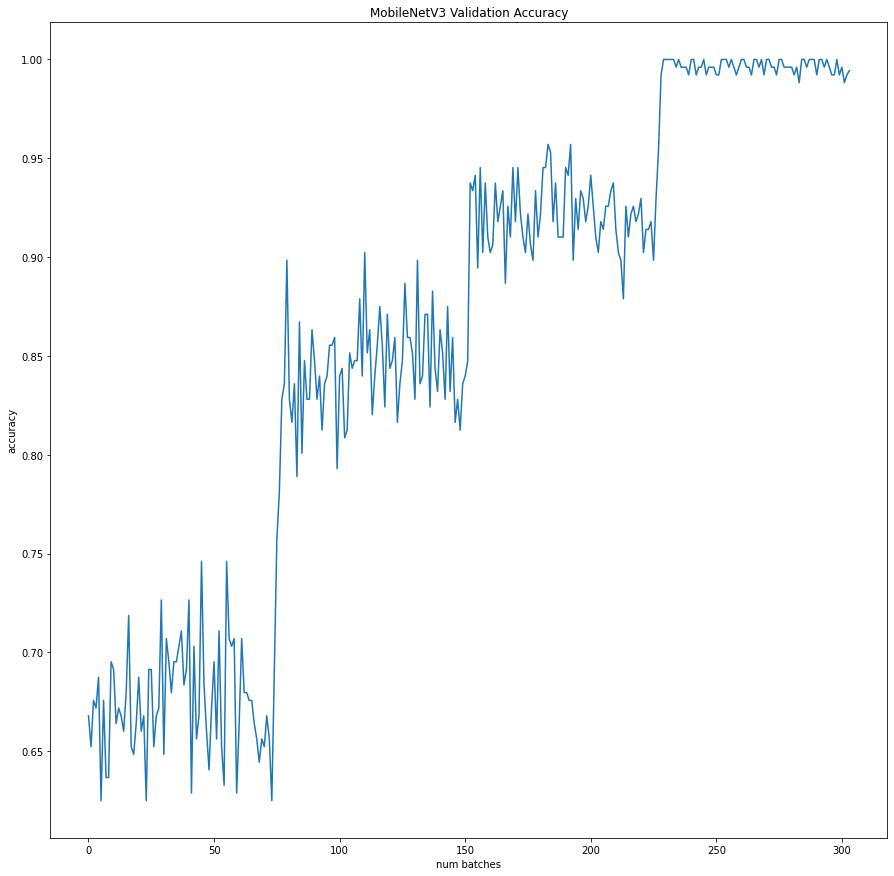

In [30]:
plt.figure(figsize=(15, 15))
plt.plot( val_all_metrics.acc + val_all_metrics2.acc)
plt.title('MobileNetV3 Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('num batches')
plt.show()

In [31]:
train_history.history

{'epoch1': {'loss': 0.5426773465365815,
  'acc': 0.7002896529639757,
  'f1': 0.6943871256465071,
  'auc': 0.7001134508262065,
  'precision': 0.7035037607367894,
  'recall': 0.7002896529639757},
 'epoch2': {'loss': 0.18110503256320953,
  'acc': 0.9265618466942315,
  'f1': 0.9265579730869455,
  'auc': 0.9268576511437985,
  'precision': 0.9273769769163535,
  'recall': 0.9265618466942315},
 'epoch3': {'loss': 0.04958239740444173,
  'acc': 0.9821572343140248,
  'f1': 0.9821596870652369,
  'auc': 0.9822892095272773,
  'precision': 0.9823068622798385,
  'recall': 0.9821572343140248}}

In [34]:
# train_aggregated_metrics = dict()
for metric in train_history2.history["epoch1"].keys():
#     vals = []
#     for epoch in train_history.history.keys():
#         vals.append(train_history.history[epoch][metric])
    train_aggregated_metrics[metric].append(train_history2.history["epoch1"][metric])

In [35]:
train_aggregated_metrics

{'loss': [0.5426773465365815,
  0.18110503256320953,
  0.04958239740444173,
  0.011380445988088336],
 'acc': [0.7002896529639757,
  0.9265618466942315,
  0.9821572343140248,
  0.9962202113309353],
 'f1': [0.6943871256465071,
  0.9265579730869455,
  0.9821596870652369,
  0.9962204929613279],
 'auc': [0.7001134508262065,
  0.9268576511437985,
  0.9822892095272773,
  0.9962574926187269],
 'precision': [0.7035037607367894,
  0.9273769769163535,
  0.9823068622798385,
  0.996240672477087],
 'recall': [0.7002896529639757,
  0.9265618466942315,
  0.9821572343140248,
  0.9962202113309353]}

In [54]:
# val_aggregated_metrics = dict()
for metric in val_history2.history["epoch1"].keys():
#     vals = []
#     for epoch in val_history.history.keys():
#         vals.append(val_history.history[epoch][metric])
    val_aggregated_metrics[metric].append(val_history2.history["epoch1"][metric])

In [55]:
val_aggregated_metrics

{'loss': [1.2223745286464691,
  0.5646233754722696,
  0.285474283914817,
  0.010326243691930645],
 'acc': [0.6759769690380613,
  0.8435931924620874,
  0.9220512632879869,
  0.9966361879274458],
 'f1': [0.6634470399748522,
  0.8421523568579264,
  0.9219368878375702,
  0.9966363051694714],
 'auc': [0.6765086988702719,
  0.843863804292551,
  0.9222320463358324,
  0.9966432587111803],
 'precision': [0.7087918975807556,
  0.8578581208728889,
  0.9252924658142627,
  0.9966596779902632],
 'recall': [0.6759769690380613,
  0.8435931924620874,
  0.9220512632879869,
  0.9966361879274458]}

In [56]:
[i for i in range(1, len(train_aggregated_metrics['acc']) + 1)]

[1, 2, 3, 4]

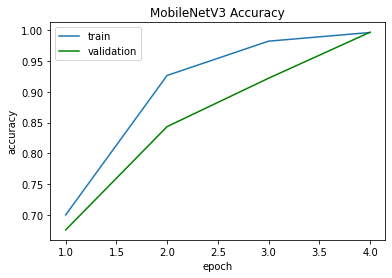

In [57]:
plt.plot([i for i in range(1, len(train_aggregated_metrics['acc']) + 1)], train_aggregated_metrics['acc'])
plt.plot([i for i in range(1, len(train_aggregated_metrics['acc']) + 1)], val_aggregated_metrics['acc'], 'g')
plt.title('MobileNetV3 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

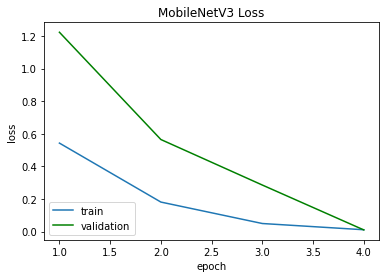

In [58]:
plt.plot([i for i in range(1, len(train_aggregated_metrics['loss']) + 1)], train_aggregated_metrics['loss'])
plt.plot([i for i in range(1, len(train_aggregated_metrics['loss']) + 1)], val_aggregated_metrics['loss'], 'g')
plt.title('MobileNetV3 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

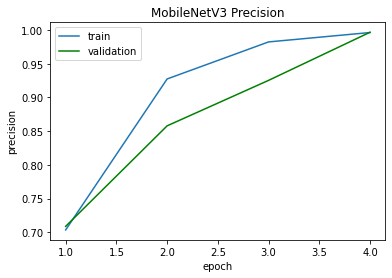

In [59]:
plt.plot([i for i in range(1, len(train_aggregated_metrics['precision']) + 1)], train_aggregated_metrics['precision'])
plt.plot([i for i in range(1, len(train_aggregated_metrics['acc']) + 1)], val_aggregated_metrics['precision'], 'g')
plt.title('MobileNetV3 Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

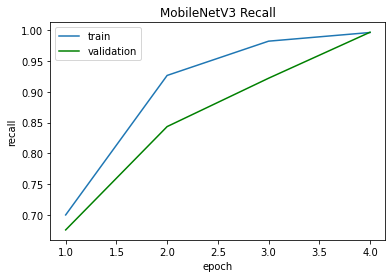

In [60]:
plt.plot([i for i in range(1, len(train_aggregated_metrics['precision']) + 1)], train_aggregated_metrics['recall'])
plt.plot([i for i in range(1, len(train_aggregated_metrics['acc']) + 1)], val_aggregated_metrics['recall'], 'g')
plt.title('MobileNetV3 Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

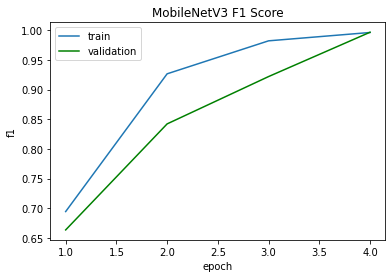

In [61]:
plt.plot([i for i in range(1, len(train_aggregated_metrics['precision']) + 1)], train_aggregated_metrics['f1'])
plt.plot([i for i in range(1, len(train_aggregated_metrics['acc']) + 1)], val_aggregated_metrics['f1'], 'g')
plt.title('MobileNetV3 F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

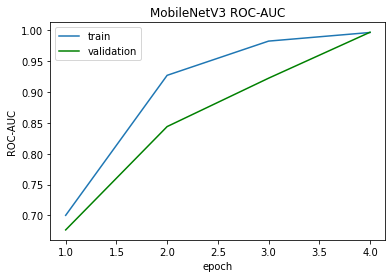

In [62]:
plt.plot([i for i in range(1, len(train_aggregated_metrics['precision']) + 1)], train_aggregated_metrics['auc'])
plt.plot([i for i in range(1, len(train_aggregated_metrics['acc']) + 1)], val_aggregated_metrics['auc'], 'g')
plt.title('MobileNetV3 ROC-AUC')
plt.ylabel('ROC-AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [23]:
class StockDatagen:
    def __init__(self, img_dir: str, label_dir: str, val_size: int):
        
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.val_size = val_size
        self.img_paths = self.__generate_paths(path_img, "*.png")


    def get_training_generators(self, batch_size: int):
        
        train_gen = DataGenerator(label_path = path_labels, batch_size = batch_size,
                                  img_paths = self.img_paths[:len(self.img_paths) - self.val_size])
        valid_gen = DataGenerator(label_path = path_labels, batch_size = batch_size,
                                  img_paths = self.img_paths[len(self.img_paths) - self.val_size:])

#         return train_gen, valid_gen
        return DataLoader(train_gen, batch_size = batch_size, num_workers = 1), \
               DataLoader(valid_gen, batch_size = batch_size, num_workers = 1)

    
    def __generate_paths(self, path, pattern):
        return glob.glob(path + pattern)

In [24]:
class DataGenerator(torch.utils.data.Dataset):
    
    def __init__(self, label_path: str, batch_size: int, img_paths):

        self.batch_size = batch_size
        self.image_paths = img_paths
        self.label_df = self.__generate_label_df(label_path)

    def __len__(self):
        return math.ceil(len(self.image_paths) / self.batch_size)

    def __getitem__(self, index):
        from_idx = index * self.batch_size
        to_idx =  len(self.image_paths) if (index + 1) * self.batch_size > len(self.image_paths) else (index + 1) * self.batch_size
        image_paths = self.image_paths[from_idx : to_idx]      
        
        data_train = []
        data_labels = []
        for image_path in image_paths:
            image_name = ntpath.basename(image_path)
            ticker, label_idx = self.__get_ticker_index(image_name)
            img = cv2.imread(image_path)
            data_train.append(img)
            data_labels.append(self.label_df[ticker].loc[int(label_idx) - 1])
            
        return torch.mul(torch.tensor(data_train, dtype = torch.float32),1/255).permute(0,3,1,2), torch.tensor(data_labels, dtype = torch.float32)

    def __generate_paths(self, path, pattern):
        """
            Creates an array of paths
        """
        return glob.glob(path + pattern)
        
    def __generate_label_df(self, label_path):
        labels_paths = self.__generate_paths(label_path, "*.rda")
#         print(labels_paths)
        labels_df = pd.DataFrame()
        
        for label_file_path in labels_paths:
            label_file_name = ntpath.basename(label_file_path)
            label_df = pyreadr.read_r(label_file_path)
            ticker = label_file_name[:label_file_name.rfind('-')]
            labels_df[ticker] = label_df['labels']['labels'].to_numpy()
            labels_df = labels_df.copy()
        
        return labels_df 
    
    def __get_ticker_index(self, s):
        head = s.split('.')[0].rstrip('0123456789')
        tail = s[len(head):len(s) - 4]
        return head, tail
    
    def on_epoch_end(self):
        self.images = random.shuffle(self.image_paths)

In [7]:
path_img = "/tmp/img_data/img/"
path_labels = "/tmp/img_data/"

In [25]:
datagen = StockDatagen(path_img, path_labels, 20000)

In [26]:
train_gen, valid_gen = datagen.get_training_generators(256)

/tmp/ipykernel_1131388/1006817476.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  labels_df[ticker] = label_df['labels']['labels'].to_numpy()


In [9]:
x, y = train_data_loader[20]

In [16]:
dataiter = iter(train_data_loader)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

In [17]:
img, lab = dataiter.next()

In [19]:
lab.shape

torch.Size([1, 256])

In [10]:
x.shape

torch.Size([256, 3, 200, 200])

In [8]:
class Dltb(pl.LightningModule):

    def __init__(self):
        super(Dltb, self).__init__()
        
        self.model = mobilenet_v3_large
        self.num_classes = 2
        self.datagen = stock_datagen
        self.train_gen = train_data_loader
        self.valid_gen = val_data_loader

    def forward(self, x):
    
        return self.model(x)

    def training_step(self, batch, batch_nb):
        # batch
        x, labels = batch
         
        # fwd
        y_hat = self(x)
        
        # loss
        loss = F.binary_cross_entropy(y_hat, label)
        
        # logs
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        # batch
        x, labels = batch
         
        # fwd
        y_hat = self.forward(x)
        
        # loss
        loss = F.binary_cross_entropy(y_hat, label)
        
        # acc
        a, y_hat = torch.where(y_hat < 0.5, 0, y_hat)
        val_acc = accuracy_score(y_hat.cpu(), label.cpu())
        val_acc = torch.tensor(val_acc)

        return {'val_loss': loss, 'val_acc': val_acc}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_val_acc = torch.stack([x['val_acc'] for x in outputs]).mean()

        tensorboard_logs = {'val_loss': avg_loss, 'avg_val_acc': avg_val_acc}
        return {'val_loss': avg_loss, 'progress_bar': tensorboard_logs}

    def test_step(self, batch, batch_nb):
        x, labels = batch
        
        y_hat = self(x)
        
        a, y_hat = torch.where(y_hat < 0.5, 0, y_hat)
        test_acc = accuracy_score(y_hat.cpu(), label.cpu())
        
        return {'test_acc': torch.tensor(test_acc)}

    def test_epoch_end(self, outputs):

        avg_test_acc = torch.stack([x['test_acc'] for x in outputs]).mean()

        tensorboard_logs = {'avg_test_acc': avg_test_acc}
        return {'avg_test_acc': avg_test_acc, 'log': tensorboard_logs, 'progress_bar': tensorboard_logs}
    
    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=2e-05, eps=1e-08)

    def train_dataloader(self):
        return self.train_gen

#     def val_dataloader(self):
#         return bert_mnli_val_dataloader

    def test_dataloader(self):
        return self.valid_gen

In [ ]:
dltb = Dltb()

trainer = pl.Trainer(gpus=1)    
trainer.fit(dltb) 